In [2]:
library(phyloseq)
library(ggplot2)
library(vegan)
library(readr)
library(data.table)
library(dplyr)
library(stats)
library(ggpubr)
library(dunn.test)
#library(DESeq2)

In [3]:
#5krare
cadaver = readRDS("/gpfs/data/gilbert-lab/Lutz/Cadaver/All_cohorts/RDSfiles/all_cohorts_cadaver_5krare.rds")

#transform
cadaver.t = cadaver %>%
    transform_sample_counts(function(x) x / sum(x))

In [4]:
cadaver.df = data.frame(sample_data(cadaver.t))
head(cadaver.df$The_manner_of_death)

[1] Accident      Homicide      Accident      Natural       Natural      
[6] Natural death
8 Levels: Accident ... Undetermined

In [5]:
#Replace variable manners of death with correct category
cadaver.df$The_manner_of_death = as.character(cadaver.df$The_manner_of_death)
cadaver.df$The_manner_of_death[cadaver.df$The_manner_of_death == 'Accident_road traffic accident'] <- 'Accident'
cadaver.df$The_manner_of_death[cadaver.df$The_manner_of_death == 'Accident_Road traffic accident'] <- 'Accident'
cadaver.df$The_manner_of_death[cadaver.df$The_manner_of_death == 'Natural death'] <- 'Natural'
cadaver.df$The_manner_of_death[cadaver.df$The_manner_of_death == 'Undetermined'] <- 'Natural'
cadaver.df$The_manner_of_death = as.factor(cadaver.df$The_manner_of_death)
head(cadaver.df$The_manner_of_death)

[1] Accident Homicide Accident Natural  Natural  Natural 
Levels: Accident Homicide Natural Suicide

In [8]:
# UNWEIGHTED UNIFRAC - Effect of Locality
cadaver.dist.unif = distance(cadaver.t, method = "unifrac", type = "samples")
cadaver.unif.nostrata.adtest = adonis2(cadaver.dist.unif ~ Location, data=cadaver.df)
cadaver.unif.nostrata.adtest

Warning message in UniFrac(physeq, ...):
“Randomly assigning root as -- TACGTAGGGTGCGAGCGTTATCCGGAATTATTGGGCGTAAAGAGCTCGTAGGCGGTTTGTCGCGTCTGTCGTGAAAGTCCGGGGCTTAACCCCGGATCTGCGGTGGGTACGGGCAGACTAGAGTGCAGTAGGGGAGACTGGAATTCCTGG -- in the phylogenetic tree in the data you provided.”

,Df,SumOfSqs,R2,F,Pr(>F)
Location,2,8.627492,0.182605,17.8719,0.001
Residual,160,38.619254,0.817395,NA,NA
Total,162,47.246746,1.000000,NA,NA


In [20]:
# UNWEIGHTED UNIFRAC - Effect of Organ
cadaver.dist.unif = distance(cadaver.t, method = "unifrac", type = "samples")
cadaver.unif.nostrata.adtest = adonis2(cadaver.dist.unif ~ Organ, data=cadaver.df)
cadaver.unif.nostrata.adtest

Warning message in UniFrac(physeq, ...):
“Randomly assigning root as -- TACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGCAGGCGGTCCTTTAAGTCTGATGTGAAAGCCCACGGCTCAACCGTGGAGGGTCATTGGAAACTGGGGGACTTGAGTACAGAAGAGGAAAGCGGAATTCCACG -- in the phylogenetic tree in the data you provided.”

,Df,SumOfSqs,R2,F,Pr(>F)
Organ,6,3.710131,0.07603079,2.139466,0.001
Residual,156,45.087619,0.92396921,NA,NA
Total,162,48.797750,1.00000000,NA,NA


In [21]:
# UNWEIGHTED UNIFRAC - Marginal effects of other variables, controlling for Locality
cadaver.dist.unif = distance(cadaver.t, method = "unifrac", type = "samples")
cadaver.unif.adtest = adonis2(cadaver.dist.unif ~ Sex + Ethnicity + Age + The_manner_of_death + PMI + bmi, strata = Location, by = "margin", data=cadaver.df)
cadaver.unif.adtest

Warning message in UniFrac(physeq, ...):
“Randomly assigning root as -- TACGTAGGGGGCGAGCGTTATCCGGATTCATTGGGCGTAAAGCGCGCGTAGGCGGCCGCGTAGGCGGGGGGTCAAATCCCGGGGCTCAACCCCGGTCCGCCCCCCGAACCCCGCGGCTCGGGTCCGGTAGGGGAGGGTGGAATTCCCGGT -- in the phylogenetic tree in the data you provided.”

,Df,SumOfSqs,R2,F,Pr(>F)
Sex,1,0.4116857,0.008911364,1.672230,0.060
Ethnicity,3,4.0338785,0.087317491,5.461751,0.001
Age,1,0.7265359,0.015726625,2.951124,0.002
The_manner_of_death,3,1.1597614,0.025104240,1.570282,0.016
PMI,1,0.3652266,0.007905710,1.483518,0.093
bmi,1,0.4051482,0.008769854,1.645676,0.043
Residual,152,37.4208143,0.810012415,NA,NA
Total,162,46.1978281,1.000000000,NA,NA


In [22]:
pval = c("0.060", "0.001", "0.002", "0.016", "0.093", "0.043")
corr.ad.test = p.adjust(pval, method = "bonferroni")
corr.ad.test

[1] 0.360 0.006 0.012 0.096 0.558 0.258

#### PCoA Plots

Warning message in UniFrac(physeq, ...):
“Randomly assigning root as -- TACGTAGGGAGCAAGCGTTGTCCGGAATTACTGGGCGTAAAGGGTGCGTAGGCGGCCGTTTAAGTCAGATGTGAAATACCCGTGCTTAACATGGGGGCTGCATTTGAAACTGGATGGCTTGAGTGCAGGAGAGGCAAGTGGAATTCCTAG -- in the phylogenetic tree in the data you provided.”

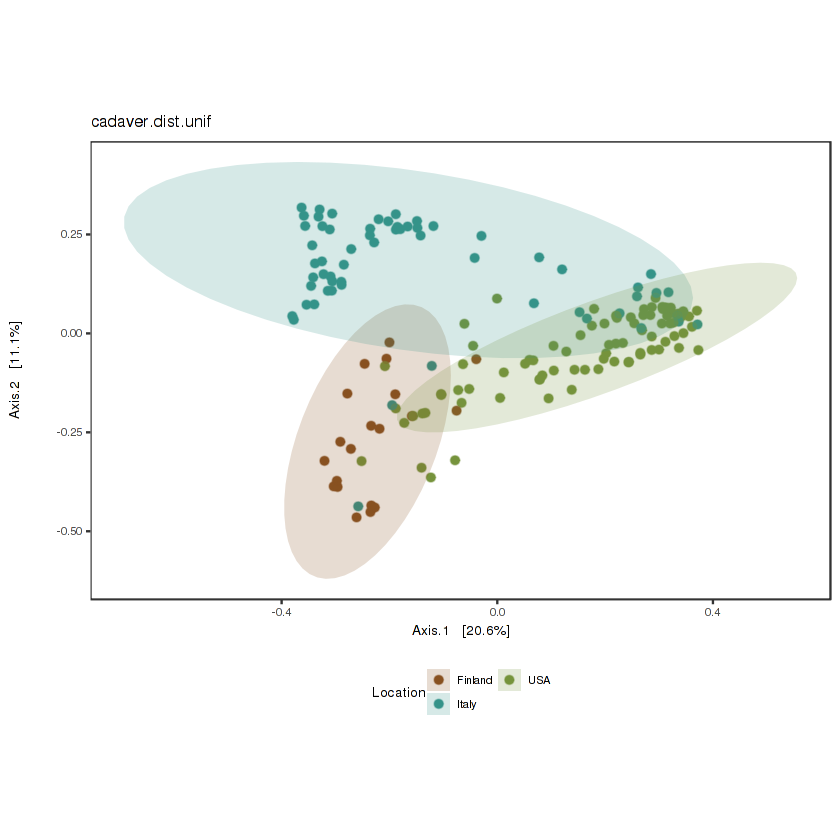

In [21]:
cadaver.dist.unif.log = ordinate(cadaver.t, method = "PCoA", distance = "unifrac")
cadaver.dist.unif.evals = cadaver.dist.unif.log$values$Eigenvalues
p = plot_ordination(cadaver.t, cadaver.dist.unif.log, color = "Location") + 
    ggtitle("cadaver.dist.unif") + 
    geom_point(size=2, alpha=0.4) + 
    #scale_colour_brewer(palette='BrBG') +
    scale_colour_manual(values=c("#885122", #Finland
                                 "#35938B", #Italy
                                 "#77933C")) + #USA
    stat_ellipse(level=0.95, geom="polygon",alpha = .2, aes(fill = Location), linetype=0) +
    #scale_fill_brewer(palette='BrBG')+
    scale_fill_manual(values=c("#885122", #Finland
                                 "#35938B", #Italy
                                 "#77933C")) + #USA
    coord_fixed(sqrt(cadaver.dist.unif.evals[2] / cadaver.dist.unif.evals[1]))

p = p + guides(colour = guide_legend(title = "Location", ncol = 2, keywidth = 1, keyheight = 1))

p = p + theme_bw() + 
        theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              text=element_text(size=8, color="black",family="Arial"),
              panel.grid.minor = element_blank(),
              #axis.ticks = element_blank(),
              #legend.key.size = unit(.1, "in"),
              #legend.spacing.x = unit(.01,"in"),
              legend.position = "bottom")


p

#png('PCoA_fecal_diet.unif.png', width=6, height=5, units='in', res=300)
#plot(p)
#dev.off()

Warning message in UniFrac(physeq, ...):
“Randomly assigning root as -- TACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGAGCATGTAGGCGGGCTTTTAAGTCTGACGTGAAAATGCGGGGCTTAACCCCGTATGGCGTTGGATACTGGAAGTCTTGAGTGCAGGAGAGGAAAGGGGAATTCTCAGT -- in the phylogenetic tree in the data you provided.”

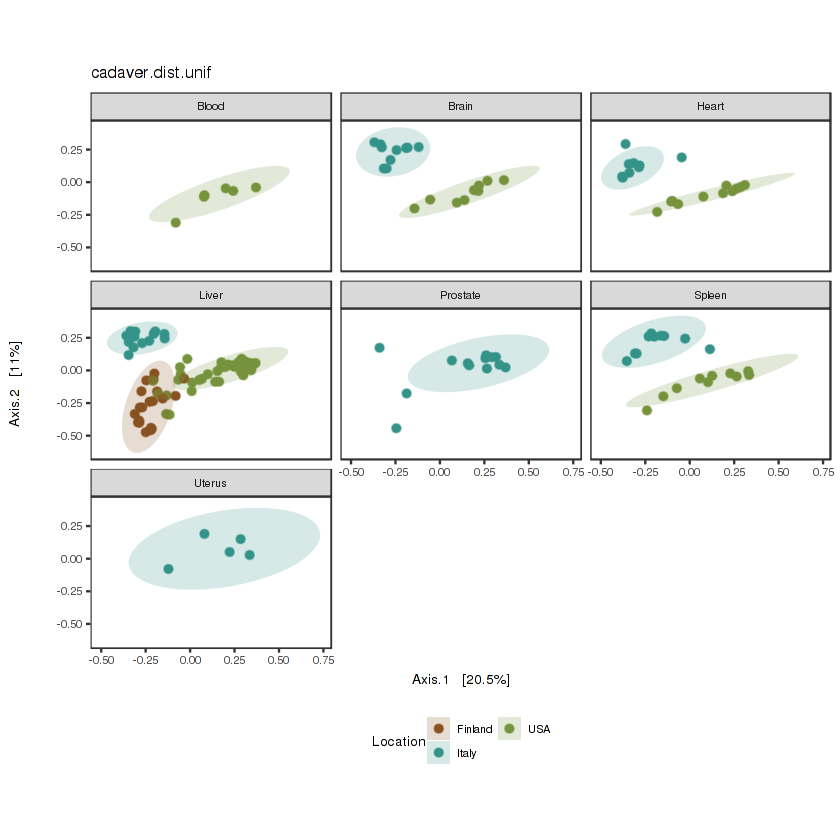

In [22]:
cadaver.dist.unif.log = ordinate(cadaver.t, method = "PCoA", distance = "unifrac")
cadaver.dist.unif.evals = cadaver.dist.unif.log$values$Eigenvalues
p = plot_ordination(cadaver.t, cadaver.dist.unif.log, color = "Location") + 
    ggtitle("cadaver.dist.unif") + 
    geom_point(size=2, alpha=0.4) + 
    #scale_colour_brewer(palette='BrBG') +
    scale_colour_manual(values=c("#885122", #Finland
                                 "#35938B", #Italy
                                 "#77933C")) + #USA
    stat_ellipse(level=0.95, geom="polygon",alpha = .2, aes(fill = Location), linetype=0) +
    #scale_fill_brewer(palette='BrBG')+
    scale_fill_manual(values=c("#885122", #Finland
                                 "#35938B", #Italy
                                 "#77933C")) + #USA
    coord_fixed(sqrt(cadaver.dist.unif.evals[2] / cadaver.dist.unif.evals[1]))

p = p + guides(colour = guide_legend(title = "Location", ncol = 2, keywidth = 1, keyheight = 1))

p = p + theme_bw() + 
        theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              text=element_text(size=8, color="black",family="Arial"),
              panel.grid.minor = element_blank(),
              #axis.ticks = element_blank(),
              #legend.key.size = unit(.1, "in"),
              #legend.spacing.x = unit(.01,"in"),
              legend.position = "bottom")


p = p + facet_wrap(~Organ)

p
#png('PCoA_fecal_diet.unif.png', width=6, height=5, units='in', res=300)
#plot(p)
#dev.off()

Warning message in UniFrac(physeq, ...):
“Randomly assigning root as -- TACGTAGGGTGCGAGCGTTGTCCGGAATTATTGGGCGTAAAGGGCTCGTAGGCGGTCTGTCGCGTCGGGAGTGAAAACTCAGGGCTTAACCCTGAGCCTGCTTCCGATACGGGCAGACTAGAGGTATGCAGGGGAGAATGGAATTCCTGG -- in the phylogenetic tree in the data you provided.”

png 
  2

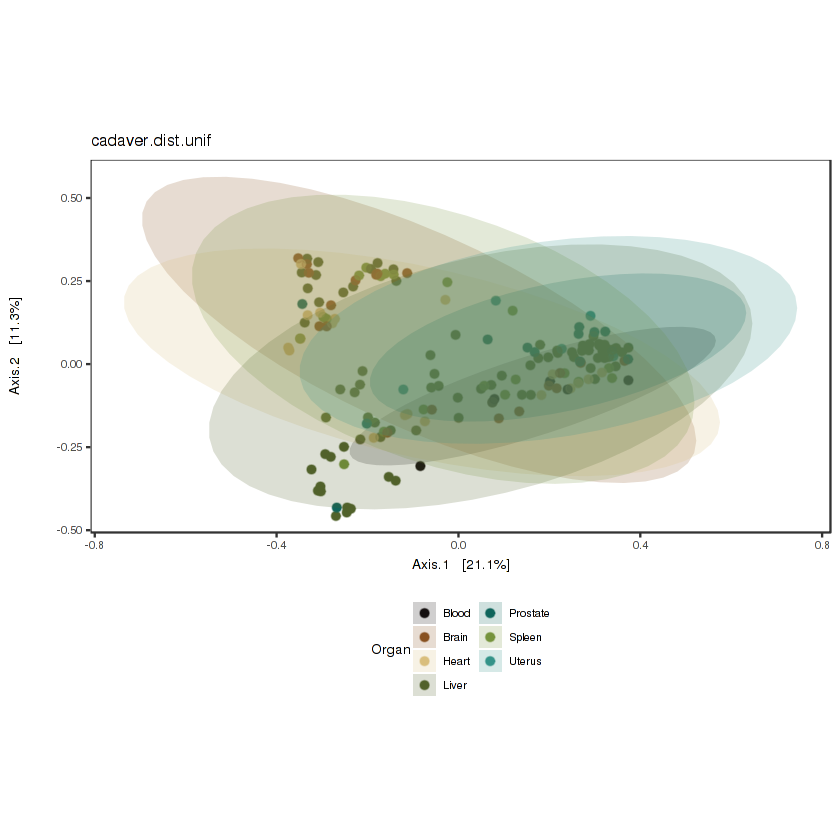

In [17]:
cadaver.dist.unif.log = ordinate(cadaver.t, method = "PCoA", distance = "unifrac")
cadaver.dist.unif.evals = cadaver.dist.unif.log$values$Eigenvalues
p = plot_ordination(cadaver.t, cadaver.dist.unif.log, color = "Organ") + 
    ggtitle("cadaver.dist.unif") + 
    geom_point(size=2, alpha=0.4) + 
    #scale_colour_brewer(palette='BrBG') +
    scale_colour_manual(values=c("#161110",
                                "#885122",
                                "#DABE7D",
                                "#51632C",
                                "#0F645C",
                                "#77933C",
                                "#35938B")) +
    stat_ellipse(level=0.95, geom="polygon",alpha = .2, aes(fill = Organ), linetype=0) +
    #scale_fill_brewer(palette='BrBG')+
    scale_fill_manual(values=c("#161110",
                                "#885122",
                                "#DABE7D",
                                "#51632C",
                                "#0F645C",
                                "#77933C",
                                "#35938B")) +
    coord_fixed(sqrt(cadaver.dist.unif.evals[2] / cadaver.dist.unif.evals[1]))

p = p + guides(colour = guide_legend(title = "Organ", ncol = 2, keywidth = 1, keyheight = 1))

p = p + theme_bw() + 
        theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              text=element_text(size=8, color="black",family="Arial"),
              panel.grid.minor = element_blank(),
              #axis.ticks = element_blank(),
              #legend.key.size = unit(.1, "in"),
              #legend.spacing.x = unit(.01,"in"),
              legend.position = "bottom")


#p = p + facet_wrap(~Organ)

p

png('PCoA_organs.unif.png', width=6, height=5, units='in', res=300)
plot(p)
dev.off()

Warning message in UniFrac(physeq, ...):
“Randomly assigning root as -- TACGTAGGGGGCGAGCGTTATCCGGAATTACTGGGTGTAAAGGGTGCGTAGGCGGTACGGCAAGTTTGATGTGAAACCCTCGGGCTTAACCCGAGGCATGCATCGAAAACTACAGAACTAGAGTGCAGGAGAGGAAAGCGGAATTCCTAG -- in the phylogenetic tree in the data you provided.”

png 
  2

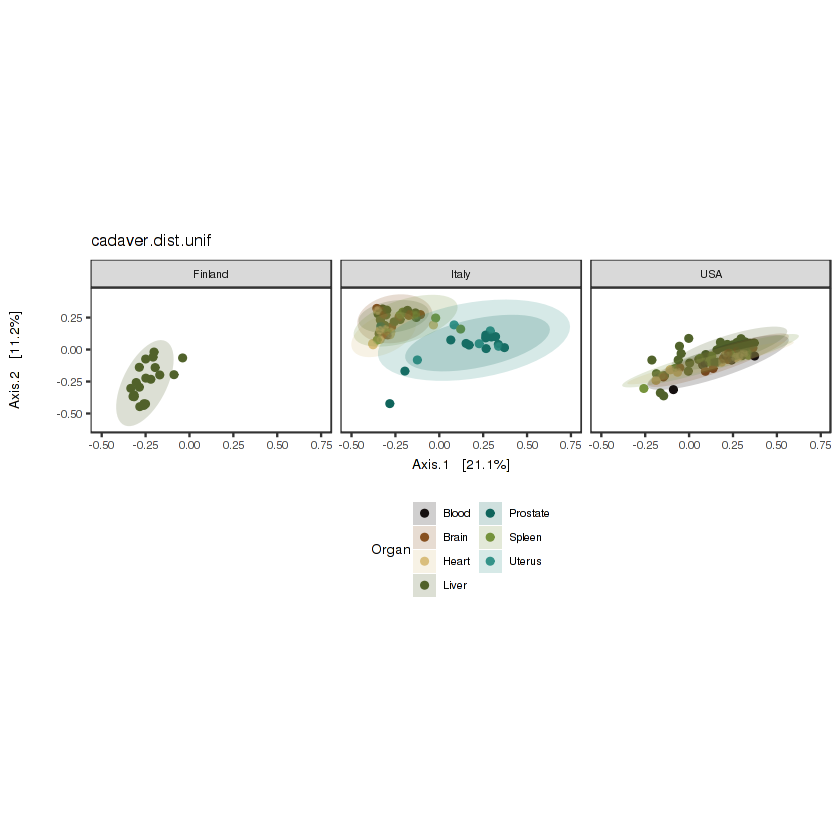

In [19]:
cadaver.dist.unif.log = ordinate(cadaver.t, method = "PCoA", distance = "unifrac")
cadaver.dist.unif.evals = cadaver.dist.unif.log$values$Eigenvalues
p = plot_ordination(cadaver.t, cadaver.dist.unif.log, color = "Organ") + 
    ggtitle("cadaver.dist.unif") + 
    geom_point(size=1, alpha=0.4) + 
    #scale_colour_brewer(palette='BrBG') +
    scale_colour_manual(values=c("#161110",
                                "#885122",
                                "#DABE7D",
                                "#51632C",
                                "#0F645C",
                                "#77933C",
                                "#35938B")) +
    stat_ellipse(level=0.95, geom="polygon",alpha = .2, aes(fill = Organ), linetype=0) +
    #scale_fill_brewer(palette='BrBG')+
    scale_fill_manual(values=c("#161110",
                                "#885122",
                                "#DABE7D",
                                "#51632C",
                                "#0F645C",
                                "#77933C",
                                "#35938B")) +
    coord_fixed(sqrt(cadaver.dist.unif.evals[2] / cadaver.dist.unif.evals[1]))

p = p + guides(colour = guide_legend(title = "Organ", ncol = 2, keywidth = 1, keyheight = 1))

p = p + theme_bw() + 
        theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              text=element_text(size=8, color="black",family="Arial"),
              panel.grid.minor = element_blank(),
              #axis.ticks = element_blank(),
              #legend.key.size = unit(.1, "in"),
              #legend.spacing.x = unit(.01,"in"),
              legend.position = "bottom")



p = p + facet_wrap(~Location)
p
png('PCoA_organs_facet_by_loc.unif.png', width=6, height=5, units='in', res=300)
plot(p)
dev.off()

In [ ]:
### BDIV SUBSET BY LOCATION, COLORED BY CONTINUOUS VARIABLES (AGE, PMI, BMI)

In [34]:
x = sample_data(cadaver.t)
head(as.factor(x$Age))

[1] 48 45 89 65 40 52
54 Levels: 14 16 17 20 21 22 24 28 29 30 31 32 33 34 35 38 40 41 42 43 ... 89

In [39]:
library(viridis)

Loading required package: viridisLite


Warning message in UniFrac(physeq, ...):
“Randomly assigning root as -- TACGTAGGTGGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGTAGGCGGGGATGCAAGTTGAATGTTTAAACTATCGGCTCAACTGATAGTCGCGTTCAAAACTGCAACTCTTGAGTGAAGTAGAGGTAGGCGGAATTCCTAGT -- in the phylogenetic tree in the data you provided.”

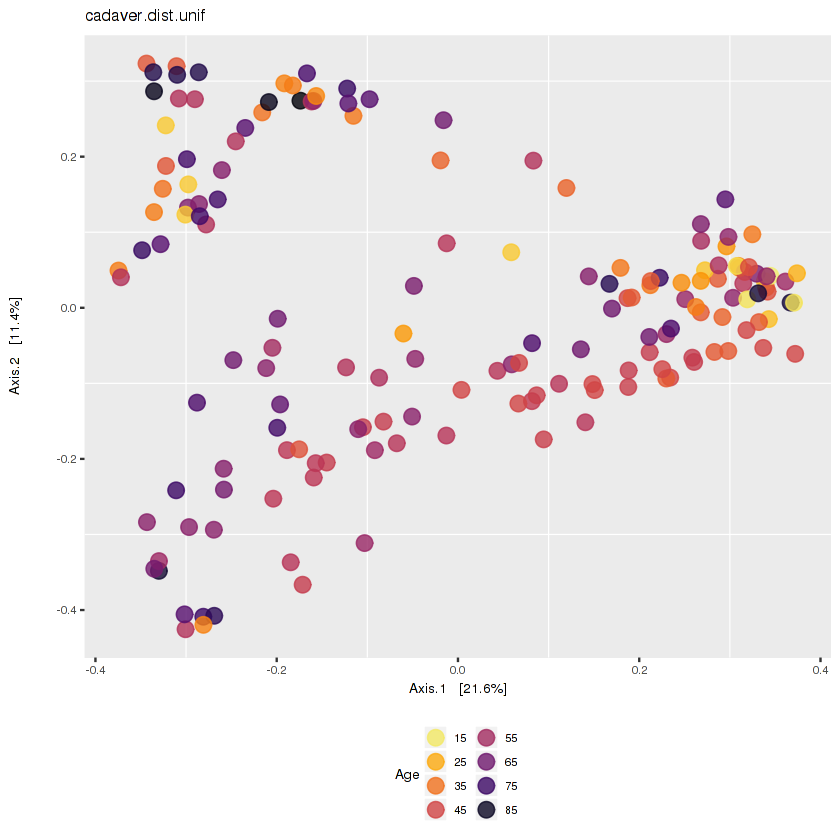

In [117]:
#b <- c('15','25','35','45','55','65','75','85','95')
b <- c(15,25,35,45,55,65,75,85,95)
cadaver.dist.unif.log = ordinate(cadaver.t, method = "PCoA", distance = "unifrac")
cadaver.dist.unif.evals = cadaver.dist.unif.log$values$Eigenvalues
p = plot_ordination(cadaver.t, cadaver.dist.unif.log, color = "Age") + 
    ggtitle("cadaver.dist.unif") + 
    geom_point(size=4, alpha=0.8) + 
    #scale_colour_brewer(palette='BrBG') +
    scale_colour_viridis(option="inferno", limits = c(10,90),
    #scale_colour_gradientn(limits = c(10,90),
    #colours=c("navyblue", "darkmagenta", "darkorange1"),
    breaks=b, labels=format(b), direction=-1)# +
    #scale_colour_manual(values=c("#885122", #Finland
    #                             "#35938B", #Italy
    #                             "#77933C")) + #USA
    #stat_ellipse(level=0.95, geom="polygon",alpha = .2, aes(fill = Organ), linetype=0) +
    #scale_fill_brewer(palette='BrBG')+
    #scale_fill_manual(values=c("#885122", #Finland
    #                             "#35938B", #Italy
    #                             "#77933C")) + #USA
    #coord_fixed(sqrt(cadaver.dist.unif.evals[2] / cadaver.dist.unif.evals[1]))

p$layers <- p$layers[2]

p = p + guides(colour = guide_legend(title = "Age", ncol = 2, keywidth = 1, keyheight = 1))

p = p + theme_gray() + 
        theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              text=element_text(size=8, color="black",family="Arial"),
              #panel.grid.minor = element_blank(),
              #axis.ticks = element_blank(),
              #legend.key.size = unit(.1, "in"),
              #legend.spacing.x = unit(.01,"in"),
              legend.position = "bottom")


#p = p + facet_wrap(~Location)

p
#png('PCoA_fecal_diet.unif.png', width=6, height=5, units='in', res=300)
#plot(p)
#dev.off()

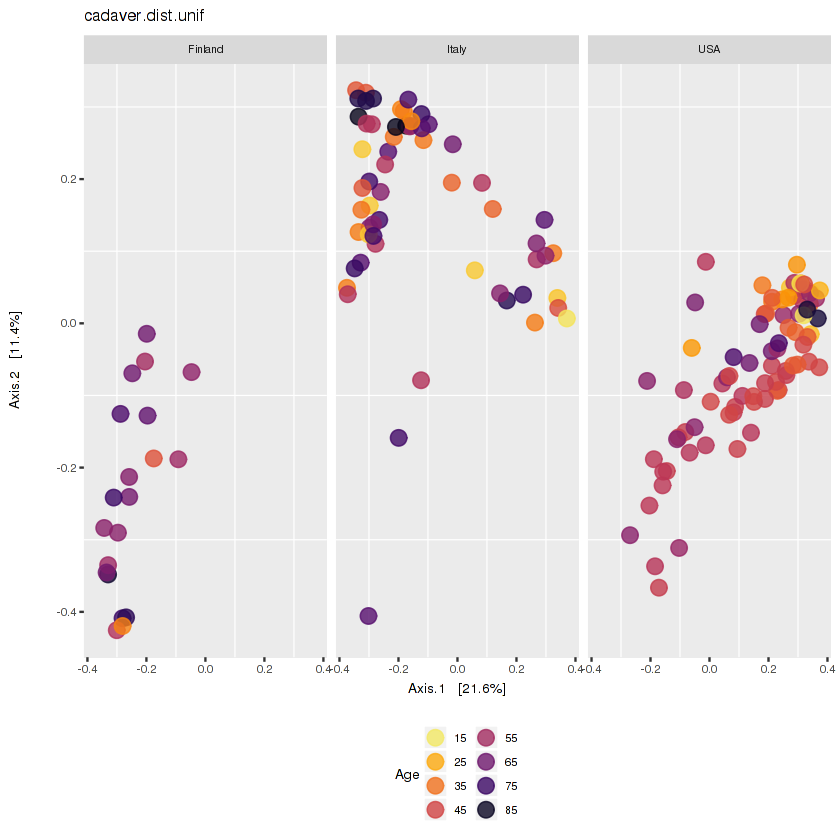

In [118]:
#Age by location
p = p + facet_wrap(~Location)
p

Warning message in UniFrac(physeq, ...):
“Randomly assigning root as -- TGGGGAATATTGCACAATGGGGGAAACCCTGATGCAGCGACGCCGCGTGAGCGAAGAAGTATTTCGGTATGTAAAGCTCTATCAGCAGGGAAGAAAATGACGGTACCTGACTAAGAAGCACCGGCTAAATACGTGCCAGCAGCCGCGGTA -- in the phylogenetic tree in the data you provided.”

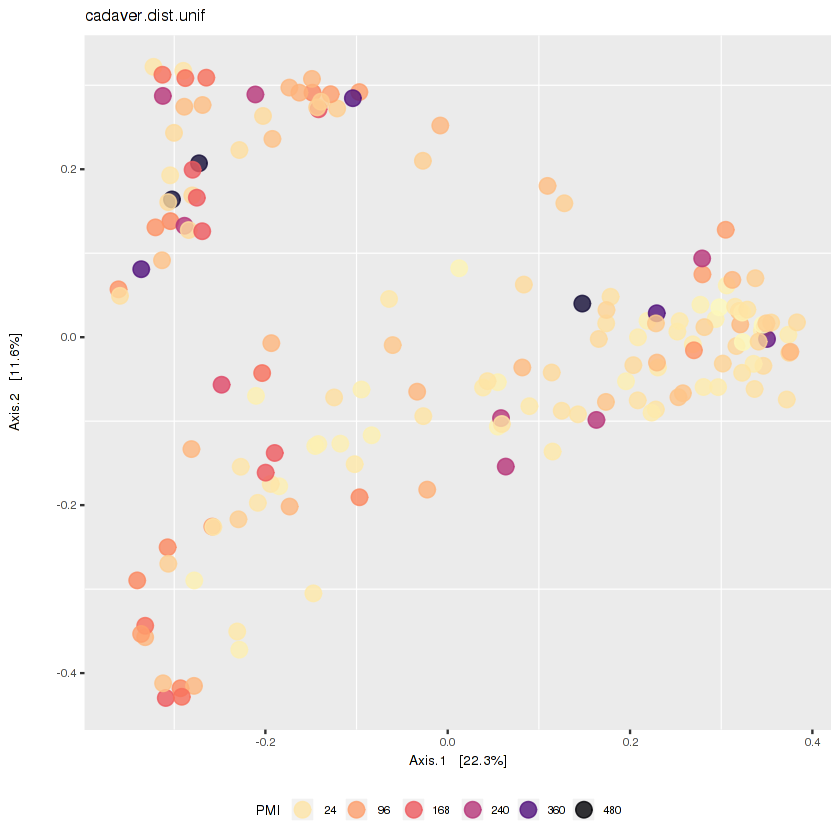

In [107]:
#b <- c('15','25','35','45','55','65','75','85','95')
#b <- c(0,24,48,72,96,120,144,168,192,216,240,264,288,312,336,360,384,408,432,456,480)
b <- c(24,96,168,240,360,480)
cadaver.dist.unif.log = ordinate(cadaver.t, method = "PCoA", distance = "unifrac")
cadaver.dist.unif.evals = cadaver.dist.unif.log$values$Eigenvalues
p = plot_ordination(cadaver.t, cadaver.dist.unif.log, color = "PMI") + 
    ggtitle("cadaver.dist.unif") + 
    geom_point(size=4, alpha=0.8) + 
    #scale_colour_brewer(palette='BrBG') +
    scale_colour_viridis(option="magma", limits = c(0,480),
    #scale_colour_gradientn(limits = c(10,90),
    #colours=c("navyblue", "darkmagenta", "darkorange1"),
    breaks=b, labels=format(b), direction=-1)# +
    #scale_colour_manual(values=c("#885122", #Finland
    #                             "#35938B", #Italy
    #                             "#77933C")) + #USA
    #stat_ellipse(level=0.95, geom="polygon",alpha = .2, aes(fill = Organ), linetype=0) +
    #scale_fill_brewer(palette='BrBG')+
    #scale_fill_manual(values=c("#885122", #Finland
    #                             "#35938B", #Italy
    #                             "#77933C")) + #USA
    #coord_fixed(sqrt(cadaver.dist.unif.evals[2] / cadaver.dist.unif.evals[1]))

p$layers <- p$layers[2]

p = p + guides(colour = guide_legend(title = "PMI", ncol = 7, keywidth = 1, keyheight = 1))

p = p + theme_gray() + 
        theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              text=element_text(size=8, color="black",family="Arial"),
              #panel.grid.minor = element_blank(),
              #axis.ticks = element_blank(),
              #legend.key.size = unit(.1, "in"),
              #legend.spacing.x = unit(.01,"in"),
              legend.position = "bottom")


p
#png('PCoA_fecal_diet.unif.png', width=6, height=5, units='in', res=300)
#plot(p)
#dev.off()

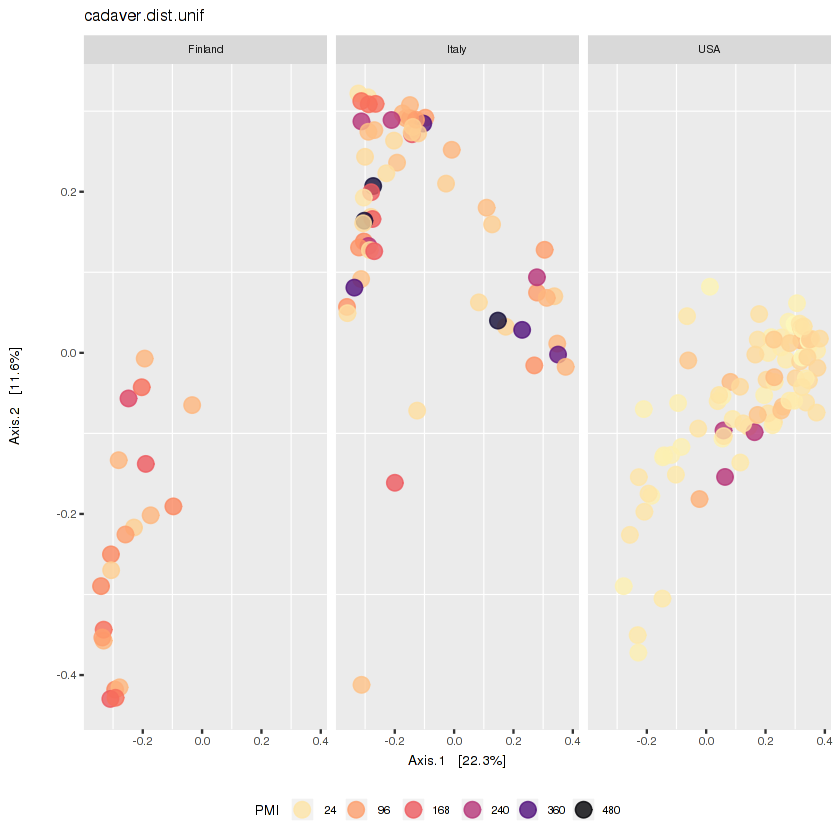

In [108]:
#PMI facet by location
p = p + facet_wrap(~Location)
p

In [81]:
map = sample_data(cadaver.t)

In [92]:
#Synchronize BMI labels
map$bmi_category = as.character(map$bmi_category)
map$bmi_category[map$bmi_category == 'normal'] <- 'Normal'
map$bmi_category[map$bmi_category == 'obese'] <- 'Obese'
map$bmi_category[map$bmi_category == 'overweight'] <- 'Overweight'
map$bmi_category[map$bmi_category == 'underweight'] <- 'Underweight'
##
map$bmi_category[map$bmi_category == 'Normal'] <- 'B_Normal'
map$bmi_category[map$bmi_category == 'Obese'] <- 'D_Obese'
map$bmi_category[map$bmi_category == 'Overweight'] <- 'C_Overweight'
map$bmi_category[map$bmi_category == 'Underweight'] <- 'A_Underweight'
map$bmi_category = as.factor(map$bmi_category)
head(map$bmi_category)

[1] B_Normal D_Obese  B_Normal B_Normal B_Normal D_Obese 
Levels: A_Underweight B_Normal C_Overweight D_Obese

In [93]:
otu = otu_table(cadaver.t)
tax = tax_table(cadaver.t)
tree = phy_tree(cadaver.t)
cadaver.t2 = merge_phyloseq(otu,tax,tree,map)

Warning message in UniFrac(physeq, ...):
“Randomly assigning root as -- TACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGGGCGCGCAGGCGGCATCGCAAGTCGGTCTTAAAAGTGCGGGGCTTAACCCCGTGAGGGGACCGAAACTGTGGAGCTCGAGTGTCGGAGAGGAAAGCGGAATTCCTAGT -- in the phylogenetic tree in the data you provided.”

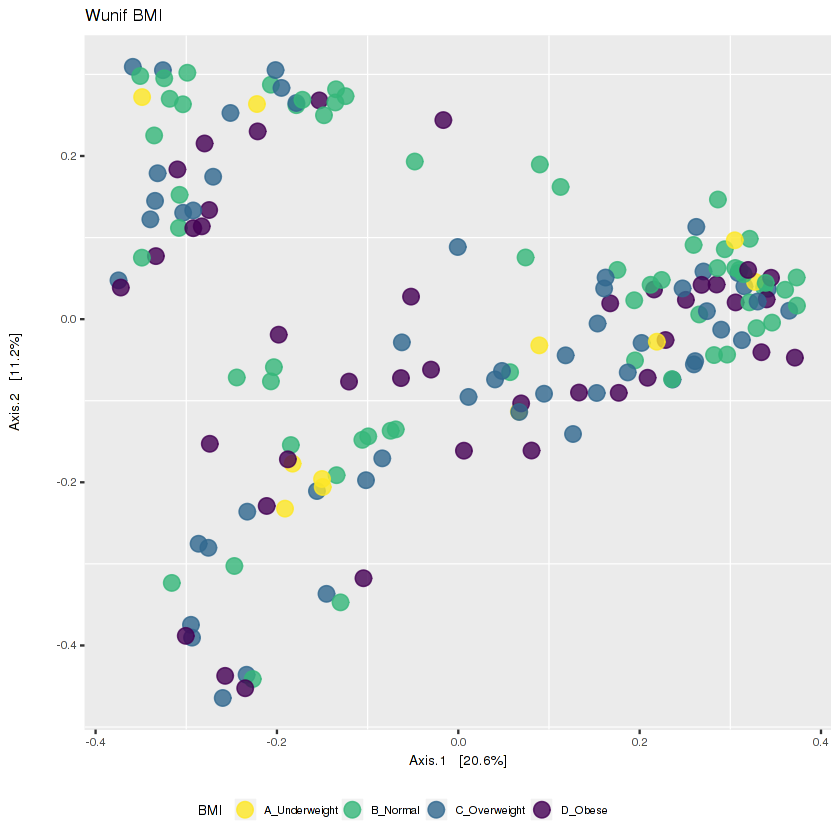

In [112]:
#b <- c('15','25','35','45','55','65','75','85','95')
#b <- c(15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49)
#b <- c(0,18.5,25,30)
cadaver.dist.unif.log = ordinate(cadaver.t2, method = "PCoA", distance = "unifrac")
cadaver.dist.unif.evals = cadaver.dist.unif.log$values$Eigenvalues
p = plot_ordination(cadaver.t2, cadaver.dist.unif.log, color = "bmi_category") + 
    ggtitle("Wunif BMI") + 
    geom_point(size=4, alpha=0.8) + 
    scale_colour_viridis(discrete=TRUE, direction=-1)# +
    #scale_colour_viridis(option="viridis", limits = c(0,50),
    #scale_colour_gradientn(limits = c(10,90),
    #colours=c("navyblue", "darkmagenta", "darkorange1"),
    #breaks=b, labels=format(b))# +
    #scale_colour_manual(values=c("#885122", #Finland
    #                             "#35938B", #Italy
    #                             "#77933C")) + #USA
    #stat_ellipse(level=0.95, geom="polygon",alpha = .2, aes(fill = Organ), linetype=0) +
    #scale_fill_brewer(palette='BrBG')+
    #scale_fill_manual(values=c("#885122", #Finland
    #                             "#35938B", #Italy
    #                             "#77933C")) + #USA
    #coord_fixed(sqrt(cadaver.dist.unif.evals[2] / cadaver.dist.unif.evals[1]))

p$layers <- p$layers[2]

p = p + guides(colour = guide_legend(title = "BMI", ncol = 7, keywidth = 1, keyheight = 1))

p = p + theme_gray() + 
        theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              text=element_text(size=8, color="black",family="Arial"),
              #panel.grid.minor = element_blank(),
              #axis.ticks = element_blank(),
              #legend.key.size = unit(.1, "in"),
              #legend.spacing.x = unit(.01,"in"),
              legend.position = "bottom")


p
#png('PCoA_fecal_diet.unif.png', width=6, height=5, units='in', res=300)
#plot(p)
#dev.off()

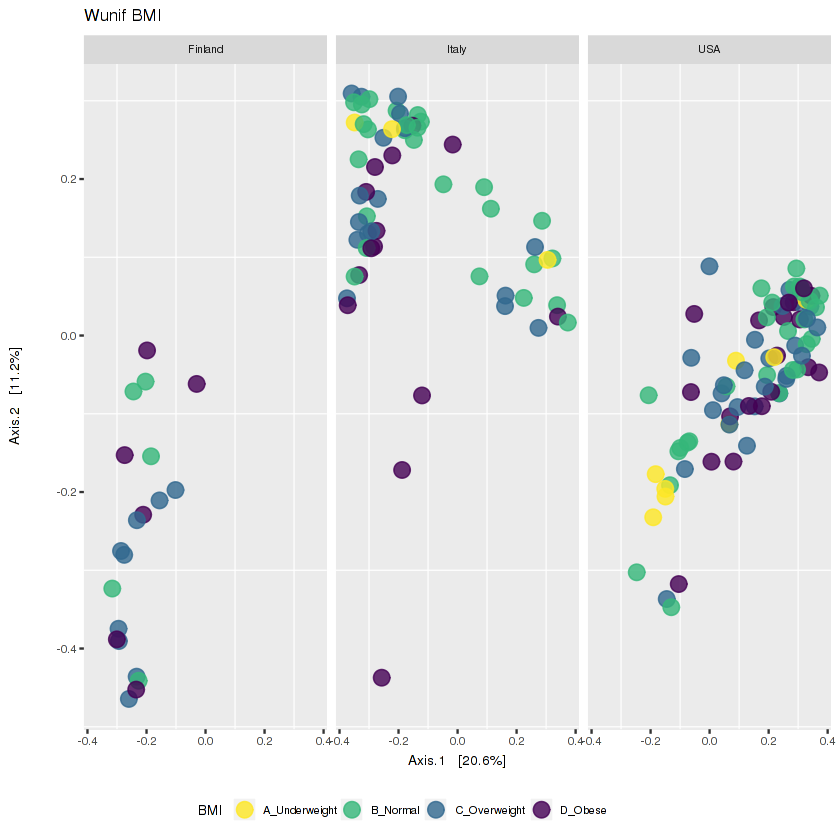

In [113]:
#BMI category by location
p = p + facet_wrap(~Location)
p